In [1]:
# ruff: noqa: E402
import pandas as pd

from jupyter_utils import JupyterUtils as JU

ju = JU()
DO_PROCESS = False

In [2]:
import json
import pathlib

root = pathlib.Path("./data/raw/IMDB-Reviews")

rows = []

for file in root.glob("*.json"):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)

    movie_id = data.get("movie_id")
    for r in data.get("reviews", []):
        rows.append(
            {
                "movie_id": movie_id,
                "title": r.get("title"),
                "review": r.get("review"),
                "rating": r.get("rating"),
            }
        )

df = pd.DataFrame(rows)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

In [3]:

df["polarity"] = df["rating"].map(lambda x: 1 if x >= 7 else 0 if x <= 4 else None)
print(df.shape)
df = df.dropna(subset=["polarity"])
print(df.shape)

(113538, 5)
(97642, 5)


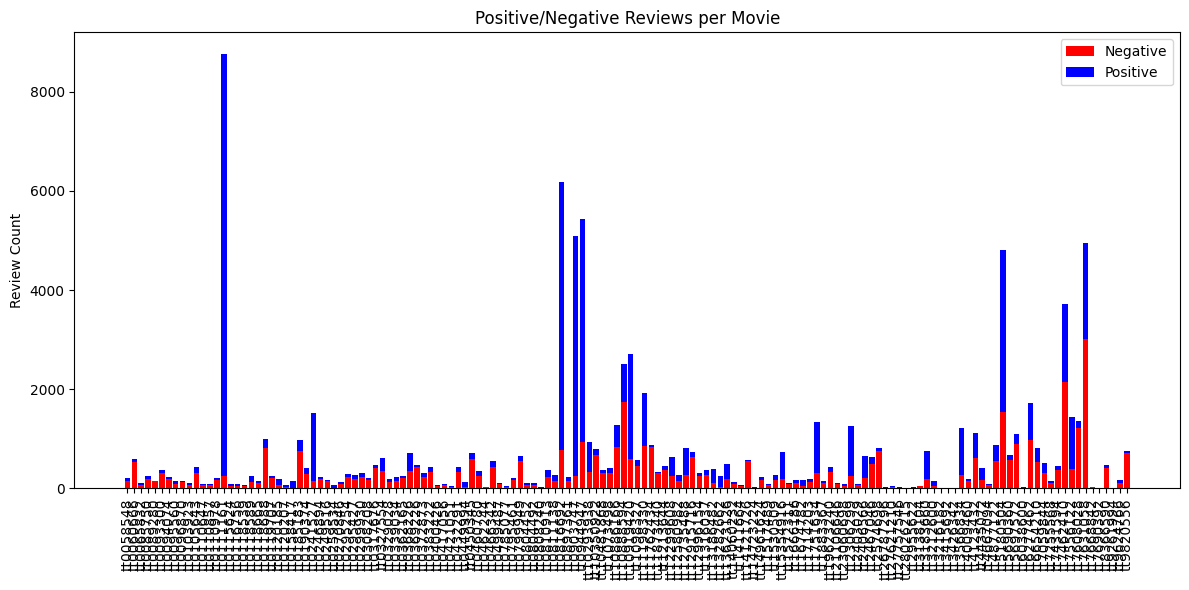

In [14]:

import matplotlib.pyplot as plt

polarity_table = (
    df.groupby(["movie_id", "polarity"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: "negative", 1: "positive"})
)

movie_ids = polarity_table.index
neg = polarity_table["negative"]
pos = polarity_table["positive"]

plt.figure(figsize=(12, 6))

plt.bar(movie_ids, neg, color="red", label="Negative")
plt.bar(movie_ids, pos, bottom=neg, color="blue", label="Positive")

plt.ylabel("Review Count")
plt.xticks(rotation=90)
plt.title("Positive/Negative Reviews per Movie")
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
df.head()

,movie_id,title,review,rating,polarity
0,tt15354916,An Action-Packed Thriller with a Powerful Mess...,"Jawan, directed by Atlee, is a must-watch for ...",8.0,1.0
1,tt15354916,An Action-Packed Thriller with a Social Consci...,"""Jawan"" is a dynamic action film that manages ...",8.0,1.0
2,tt15354916,K & A,KThe movie was amaazing the story and everythi...,8.0,1.0
3,tt15354916,must watch in theatre,This movie is really a must watch in theatre.I...,10.0,1.0
4,tt15354916,7.7 - Unexpectedly good credit to Atlee,You can tell its directed by a South Indian bu...,7.0,1.0


In [3]:

import spacy
from tqdm import tqdm

tqdm.pandas()  # enables df.progress_apply()

# Download the English model
# python -m space en_core_web_sm
nlp = spacy.load("en_core_web_sm")


# Remove stopwords and
def preprocess_review(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha
    ]
    return " ".join(tokens)


df["processed_review"] = df["review"].progress_apply(preprocess_review)

df.to_csv("./data/processed/imdb.csv", index=False)

,movie_id,title,review,rating
0,tt15354916,An Action-Packed Thriller with a Powerful Mess...,"Jawan, directed by Atlee, is a must-watch for ...",8.0
1,tt15354916,An Action-Packed Thriller with a Social Consci...,"""Jawan"" is a dynamic action film that manages ...",8.0
2,tt15354916,K & A,KThe movie was amaazing the story and everythi...,8.0
3,tt15354916,must watch in theatre,This movie is really a must watch in theatre.I...,10.0
4,tt15354916,7.7 - Unexpectedly good credit to Atlee,You can tell its directed by a South Indian bu...,7.0
